# Random Forest
The nature of our models'
 training, testing, and evaluation is that the data is split into training, testing, and validation sets. 
 
2014-2022 will be used as training and testing while 2023-2024 will be used for validation.
 
## Number of models
The models to be made are:
- 1 week ahead
- 2 weeks ahead
- 3 weeks ahead
- 4 weeks ahead
- 12 weeks ahead

Two main types of model will be made:
- Municipal Level
- Provincial Level

There are 42 municipals in the province + 1 component city, Passi City. Hence, there will be 10x43 = 430 Local Models and 1x5 = 5 Provincial Pooled Models, and 1 Provincial Summed Model.
Each n-week ahead model will have the same hyperparameters for different municipalities to avoid having too many models and avoiding unnecessary complexity.


## 10-Fold Cross Validation
The training and testing data will be used for the 10-Fold Cross Validation.
## Leave-one-season-out Cross-Validation
The leave-one-season-out cross-validation will be used to evaluate the model's performance. This means that the model will be trained on all data except for one year and tested on that year. This will be done for each year of available data..
## Utilities
Functions that serve as utilities for the models will be made in a separate file. These functions will be used to:
- Save the predicted and actual observations to a CSV file.
- save the evaluation reports to a CSV file.


In [2]:
# import necessary modules
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
import models_utils
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Cross Validation with GridSearchCV
To find the optimal hyperparameter of the Random Forest model, a GridSearchCV will be used with a cv=10.
Since 

In [2]:
def get_best_hyperparameters(df, n_week_ahead, features=["Temperature", "Humidity", "Precipitation"], target="Cases", date_col="Year-Week", pooled=False):
    """
    Function to get the best hyperparameters for the Random Forest model using GridSearchCV.
    """
    # Create a Random Forest Regressor
    if not pooled:
        # If pooled, we need to use the pooled data
        data = models_utils.prepare_dataframe(df,["Temperature", "Humidity", "Precipitation"], ["Year", "Week", "Month", "Population"],"Cases", "Year-Week", n_week_ahead)
    else:
        data = df
    X_train = data.drop(columns=['Cases', 'Year-Week'])
    y_train = data['Cases']
    rf = RandomForestRegressor()

    # Create a parameter grid to search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    return best_hyperparameters

In [3]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())
municipals

['Ajuy',
 'Alimodian',
 'Anilao',
 'Badiangan',
 'Balasan',
 'Banate',
 'Barotac Nuevo',
 'Barotac Viejo',
 'Batad',
 'Bingawan',
 'Cabatuan',
 'Calinog',
 'Carles',
 'Passi City',
 'Concepcion',
 'Dingle',
 'Duenas',
 'Dumangas',
 'Estancia',
 'Guimbal',
 'Iloilo City',
 'Igbaras',
 'Janiuay',
 'Lambunao',
 'Leganes',
 'Lemery',
 'Leon',
 'Maasin',
 'Miagao',
 'Mina',
 'New Lucena',
 'Oton',
 'Pavia',
 'Pototan',
 'San Dionisio',
 'San Enrique',
 'San Joaquin',
 'San Miguel',
 'San Rafael',
 'Santa Barbara',
 'Sara',
 'Tigbauan',
 'Tubungan',
 'Zarraga']

## For Municipal Level

In [4]:
best_parameters = []
n_weeks_ahead = [1,2,3,4,8,12]
for n in n_weeks_ahead:
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        best_params_model = get_best_hyperparameters(df = municipal_df, n_week_ahead=n)
        best_parameters.append({
            "Municipal": municipal,
            "Weeks Ahead": n,
            "Best Hyperparameters": best_params_model
        })


KeyboardInterrupt: 

In [11]:
# Checking the count of best hyperparameters
# Checking the count of best hyperparameters
best_parameters_count = {}
for param in best_parameters:
    # Convert the dictionary of hyperparameters to a tuple of sorted key-value pairs
    hyperparameters_tuple = tuple(sorted(param["Best Hyperparameters"].items()))
    if hyperparameters_tuple not in best_parameters_count:
        best_parameters_count[hyperparameters_tuple] = 1
    else:
        best_parameters_count[hyperparameters_tuple] += 1

In [12]:
#check top 3 best hyperparameters
sorted(best_parameters_count.items(), key=lambda x: x[1], reverse=True)[:3]

[((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 2),
   ('n_estimators', 100)),
  39),
 ((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 2),
   ('n_estimators', 200)),
  34),
 ((('max_depth', 5),
   ('min_samples_leaf', 2),
   ('min_samples_split', 5),
   ('n_estimators', 200)),
  32)]

In [30]:
# save best hyperparameters to a csv file
municipal = []
weeks_ahead = []
max_depth = []
min_samples_split = []
min_samples_leaf = []
n_estimators = []
for model in best_parameters:
    print(model)
    print(model["Municipal"])
    municipal.append(model["Municipal"])
    weeks_ahead.append(model["Weeks Ahead"])
    max_depth.append(model["Best Hyperparameters"]["max_depth"])
    min_samples_split.append(model["Best Hyperparameters"]["min_samples_split"])
    min_samples_leaf.append(model["Best Hyperparameters"]["min_samples_leaf"])
    n_estimators.append(model["Best Hyperparameters"]["n_estimators"])

print(len(max_depth))
best_parameters_df = pd.DataFrame({
    "Municipal": municipal,
    "Weeks Ahead": weeks_ahead,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "n_estimators": n_estimators
})
best_parameters_df.to_csv("best_hyperparameters.csv", index=False)

0


In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

class RandomForestModel:
    def __init__(self, n_estimators=100, max_depth=5, min_samples_leaf=2, min_samples_split=2):
        """
        Initialize the Random Forest Trainer with hyperparameters.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split
        self.rf_model = None
        self.feature_importance_dict = None

    def preprocess_data(self, data, features_lag, features_addtl, target, date_col, n_ahead):
        """
        Preprocess the data by creating lagged features and removing rows with missing values.
        """
        rel_col = features_lag + features_addtl + [target] + [date_col]
        data = data[rel_col]
        data[date_col] = pd.to_datetime(data[date_col])

        # Define lags
        env_lags = range(n_ahead, n_ahead + 12)
        cases_lag = range(n_ahead, n_ahead + 12)

        # Create lagged features
        for lag in env_lags:
            for feature in features_lag:
                data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

        for lag in cases_lag:
            data[f'{target}_lag_{lag}'] = data[target].shift(lag)

        # Remove rows with missing values
        data = data.dropna()

        # Remove current features to avoid data leakage
        data = data.drop(columns=features_lag + features_addtl)

        return data

    def split_data(self, data, date_col, target, year_test_start, year_test_end):
        """
        Split the data into training and testing sets.
        """
        if year_test_end == "2024-12-31":
            train_data = data[data[date_col] < year_test_start]
        else:
            train_data = data[(data[date_col] < year_test_start) | (data[date_col] >= year_test_end)]
        test_data = data[(data[date_col] >= year_test_start) & (data[date_col] < year_test_end)]

        X_train = train_data.drop(columns=[target, date_col])
        y_train = train_data[target]
        X_test = test_data.drop(columns=[target, date_col])
        y_test = test_data[target]

        return X_train, y_train, X_test, y_test

    def train(self, X_train, y_train):
        """
        Train the Random Forest model.
        """
        self.rf_model = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_leaf=self.min_samples_leaf,
            min_samples_split=self.min_samples_split,
            n_jobs=-1
        )
        self.rf_model.fit(X_train, y_train)

    def predict(self, X_test):
        """
        Predict using the trained Random Forest model.
        """
        return self.rf_model.predict(X_test)

    def evaluate(self, y_test, predictions):
        """
        Evaluate the model using MAE and MSE.
        """
        MAE = mean_absolute_error(y_test, predictions)
        MSE = mean_squared_error(y_test, predictions)
        return MAE, MSE

    def get_feature_importance(self, X_train):
        """
        Get feature importance from the trained model.
        """
        feature_importance = self.rf_model.feature_importances_
        self.feature_importance_dict = {feature: importance for feature, importance in zip(X_train.columns, feature_importance)}
        return self.feature_importance_dict

    def train_and_evaluate(self, data, features_lag, features_addtl, target, date_col, n_ahead, year_test_start, year_test_end):
        """
        Full pipeline to preprocess data, train the model, and evaluate it.
        """
        # Preprocess data
        data = self.preprocess_data(data, features_lag, features_addtl, target, date_col, n_ahead)

        # Split data
        X_train, y_train, X_test, y_test = self.split_data(data, date_col, target, year_test_start, year_test_end)

        # Train model
        self.train(X_train, y_train)

        # Predict
        predictions = self.predict(X_test)
        predictions = [int(round(x)) for x in predictions]  # Round predictions to integers

        # Evaluate
        MAE, MSE = self.evaluate(y_test, predictions)

        # Get feature importance
        feature_importance_dict = self.get_feature_importance(X_train)

        return predictions, MAE, MSE, feature_importance_dict, y_test.values

In [3]:
import sys
sys.path.append('..')
import models_utils
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
for municipal in municipals:
    for n in n_weeks_ahead:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        rf_model = RandomForestModel()
        predicted, MAE, MSE, feature_importance_dict, actual = rf_model.train_and_evaluate(
            data=municipal_df,
            features_lag=["Temperature", "Precipitation", "Humidity"],
            features_addtl=["Year", "Week", "Month", "Population"],
            target="Cases",
            date_col="Year-Week",
            n_ahead=n,
            year_test_start="2023-01-01",
            year_test_end="2024-12-31"
        )
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type = "Municipal")
        models_utils.save_feat_imp(municipal, n, feature_importance_dict, type = "Municipal")

# Pooled Provincial Model

The pooled provincial model means taking all the data from the municipalities and training a single model on it. 

This is done to see if the model can generalize well across all municipalities.

Hence, we have 43x11x52 = 24596 rows of data.

# Lagging Methods
The method for lagging the data is somewhat different for this. First, we must lag the data for each municipal, then we can pool the data together.

In [1]:
import sys
sys.path.append('..')
import models_utils
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
def get_best_hyperparameters_pooled(n_weeks_ahead, features=["Temperature", "Humidity", "Precipitation"], target="Cases", date_col="Year-Week"):
    """
    Function to get the best hyperparameters for the Random Forest model using GridSearchCV.
    """
    # Create a Random Forest Regressor
    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n_weeks_ahead)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)
    data = pooled_df
    X_train = data.drop(columns=['Cases', 'Year-Week'])
    y_train = data['Cases']
    rf = RandomForestRegressor()

    # Create a parameter grid to search
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
    }

    # Create a GridSearchCV object
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    grid_search.fit(X_train, y_train)

    # Get the best hyperparameters
    best_hyperparameters = grid_search.best_params_

    return best_hyperparameters

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_RF_provincial(X_train, y_train, hyperparameters: dict):

    # Initialize and train the Random Forest model
    rf_model = RandomForestRegressor(
        n_estimators=hyperparameters["n_estimators"],
        max_depth=hyperparameters['max_depth'],
        min_samples_leaf=hyperparameters['min_samples_leaf'],
        min_samples_split=hyperparameters['min_samples_split'],
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    return rf_model

def test_RF_provincial(model, X_test, y_test):
    # Predict on test data
    predict_data = model.predict(X_test)
    actual_data = y_test.values

    # Make predictions integer
    predict_data = [int(round(x)) for x in predict_data]

    # Calculate Mean Absolute Error and Mean Squared Error
    MAE = mean_absolute_error(actual_data, predict_data)
    MSE = mean_squared_error(actual_data, predict_data)
    # get feature importance in a dictionary
    feature_importance = model.feature_importances_
    feature_importance_dict = {}
    for i, feature in enumerate(X_test.columns):
        feature_importance_dict[feature] = feature_importance[i]
        
    return predict_data, MAE, MSE, feature_importance_dict

In [3]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
import warnings
import pandas as pd
import sys
sys.path.append('..')
import models_utils
warnings.filterwarnings("ignore")
for n in n_weeks_ahead:

    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)
    
    pooled_df.dropna()
    pooled_X = pooled_df.drop(columns=["Cases", "Year-Week"])
    pooled_y = pooled_df["Cases"]
    pooled_X_train = pooled_X[pooled_df["Year-Week"] < "2023-01-01"]
    pooled_y_train = pooled_y[pooled_df["Year-Week"] < "2023-01-01"]
    model = train_RF_provincial(pooled_X_train, pooled_y_train, {'max_depth': 15,
                                                                    'min_samples_leaf': 2,
                                                                    'min_samples_split': 2,
                                                                    'n_estimators': 100})
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        municipal_X = municipal_df.drop(columns=["Cases", "Year-Week"])
        municipal_y = municipal_df["Cases"]
        municipal_X_test = municipal_X[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        municipal_y_test = municipal_y[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        predicted, MAE, MSE, feature_importance_dict = test_RF_provincial(model, municipal_X_test, municipal_y_test)
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type = "Provincial")
        models_utils.save_feat_imp(municipal, n, feature_importance_dict, type = "Provincial")
    print(n)
        


NameError: name 'train_RF_provincial' is not defined

# Summed Provincial Model

## Table for Features and Cases recalculated

| Population | Temperature | Humidity | Precipitation | Cases |
|------------|-------------|----------|---------------|-------|
| Mean       | Median      | Median   | Median        | Sum   |

Year, Month, and Week will remain as is



In [1]:
import sys
sys.path.append('..')
import models_utils
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

In [9]:
import pandas as pd
summed_df_list = []
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 1)
    summed_df_list.append(municipal_df)
summed_df = models_utils.prepare_dataframe_summed(summed_df_list)
summed_df

/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:

,Year-Week,Temperature,Humidity,Precipitation,Cases,Population,Year,Month,Week
0,2014-04-07,29.085999,69.510519,2.800000,13.0,44424.502326,2014,4,15
1,2014-04-14,28.544785,71.990878,30.800000,8.0,44424.502326,2014,4,16
2,2014-04-21,27.360928,81.830299,224.799993,7.0,44424.502326,2014,4,17
3,2014-04-28,28.839500,75.587553,61.600004,10.0,44424.502326,2014,4,18
4,2014-05-05,29.867644,76.199511,8.800000,15.0,44424.502326,2014,5,19
...,...,...,...,...,...,...,...,...,...
555,2024-12-02,29.499572,75.246312,40.500002,104.0,49329.874419,2024,12,49
556,2024-12-09,28.566571,77.246023,56.100003,135.0,49329.874419,2024,12,50
557,2024-12-16,26.914858,85.227285,122.400006,113.0,49329.874419,2024,12,51
558,2024-12-23,27.752500,80.047471,68.699999,84.0,49329.874419,2024,12,52


In [10]:
n_head = range(1,13)
summed_df["Year-Week"] = pd.to_datetime(summed_df["Year-Week"])
feature_imp_dict = {}
for n in n_head:
    summed_df = models_utils.prepare_dataframe(summed_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
    rf_model = RandomForestModel()
    predicted, MAE, MSE, feature_importance_dict, actual = rf_model.train_and_evaluate(summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=n)
    feature_imp_dict[n] = feature_importance_dict
    models_utils.save_data("summed", n, MSE, MAE, predicted, summed_df, "Summed Provincial")

/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)
/home/miniloda/Documents/GitHub/Math-198.1---Special-Problem/model/Random-Forest/../models_utils.py:

In [14]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

{1: {'Temperature': 0.00012458443427394535,
  'Precipitation': 0.0008718367196938084,
  'Humidity': 0.00030935376790111287,
  'Year': 2.4565621551470035e-05,
  'Week': 0.001171489613885096,
  'Population': 0.0011477371041678705,
  'Month': 0.0004686145352394033,
  'Temperature_lag_1': 0.0005949384720464429,
  'Precipitation_lag_1': 0.002928498861041153,
  'Humidity_lag_1': 0.0005170594251409181,
  'Temperature_lag_2': 0.0005273419729842518,
  'Precipitation_lag_2': 0.006777467680838775,
  'Humidity_lag_2': 0.00028394284505920173,
  'Temperature_lag_3': 0.00026460185988752706,
  'Precipitation_lag_3': 0.0017713382075607575,
  'Humidity_lag_3': 0.00022975261920091358,
  'Temperature_lag_4': 0.0004090883091907178,
  'Precipitation_lag_4': 0.00020575706815275505,
  'Humidity_lag_4': 0.0006194590680381372,
  'Temperature_lag_5': 0.0001575117367718198,
  'Precipitation_lag_5': 0.0007845237820667275,
  'Humidity_lag_5': 0.0001145707863124722,
  'Temperature_lag_6': 0.0002497850272395676,
  'P

In [24]:
feature_imp_df = pd.DataFrame.from_dict(feature_imp_dict, orient="index")
feature_imp_df = feature_imp_df.T
feature_imp_df = feature_imp_df.reset_index()
feature_imp_df = feature_imp_df.melt(id_vars=["index"], var_name="n_week", value_name="Importance")
feature_imp_df.rename(columns={"index": "Feature"}, inplace=True)
feature_imp_df["Importance"] = feature_imp_df["Importance"].map(lambda x: round(x, 2))
# get the top 10 features for each n_week
feature_imp_top_10 = pd.DataFrame(columns= ["n_week", "Feature", "Importance"])
for n in range(1,13):
    feature_imp_top_10 = pd.concat([feature_imp_top_10, feature_imp_df[feature_imp_df["n_week"] == n].sort_values(by="Importance", ascending=False).head(10)], axis=0)
feature_imp_top_10

/tmp/ipykernel_7026/2438881776.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  feature_imp_top_10 = pd.concat([feature_imp_top_10, feature_imp_df[feature_imp_df["n_week"] == n].sort_values(by="Importance", ascending=False).head(10)], axis=0)


,n_week,Feature,Importance
43,1,Cases_lag_1,0.92
44,1,Cases_lag_2,0.03
11,1,Precipitation_lag_2,0.01
40,1,Temperature_lag_12,0.01
3,1,Year,0.00
...,...,...,...
1162,12,Humidity_lag_17,0.05
1166,12,Humidity_lag_18,0.03
1165,12,Precipitation_lag_18,0.03
1174,12,Humidity_lag_20,0.03


In [35]:
import re

# Create barplot for each week and save
seasonal_features = ["Month", "Week", "Year"]
meteorological_features = ["Temperature", "Precipitation", "Humidity"]
socio_features = ["Population"]
dengue_features = ["Cases"]
color_feat = {
    "#87CEEB": seasonal_features,  # Light Blue
    "#90EE90": meteorological_features,  # Light Green
    "#FF7F50": socio_features,  # Coral
    "#FFD700": dengue_features  # Gold
}

for n in range(1, 13):
    plt.figure(figsize=(10, 7))
    features = feature_imp_top_10[feature_imp_top_10["n_week"] == n]["Feature"]
    importances = feature_imp_top_10[feature_imp_top_10["n_week"] == n]["Importance"]

    # Determine bar colors based on feature type
    bar_colors = []
    for feature in features:
        if any(re.match(f"{sf}_lag_\\d+", feature) for sf in seasonal_features):
            bar_colors.append("#87CEEB")
        elif any(re.match(f"{mf}_lag_\\d+", feature) for mf in meteorological_features):
            bar_colors.append("#90EE90")
        elif any(re.match(f"{sf}_lag_\\d+", feature) for sf in socio_features):
            bar_colors.append("#FF7F50")
        elif any(re.match(f"{df}_lag_\\d+", feature) for df in dengue_features):
            bar_colors.append("#FFD700")
        else:
            bar_colors.append("#87CEEB")  # Light Gray for unmatched features

    # Create barplot
    plt.bar(features, importances, color=bar_colors)

    # Add data value for each bar
    for i, v in enumerate(importances):
        plt.text(i, v, str(v), ha="center", va="bottom", fontsize=8)

    # Add legend
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in color_feat.keys()]
    labels = ["Seasonal Features", "Meteorological Features", "Socio Features", "Dengue Features"]
    plt.legend(handles, labels, title="Feature Type", loc="upper right")

    plt.title(f"Top 10 Features for {n}-Week Ahead Prediction")
    plt.xticks(rotation=45)
    plt.ylabel("Importance")
    plt.xlabel("Feature")
    plt.tight_layout()
    plt.savefig(f"Feature Importance/top_10_features_{n}.png")
    plt.close()

In [12]:
predicted, MAE, MSE, feature_importance_dict = train_RF(summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=12, year_test_start="2023-01-01", year_test_end="2024-12-31")

NameError: name 'train_RF' is not defined

In [13]:
plt.barh(feature_importance_dict.keys(), feature_importance_dict.values(), label="Feature Importance")

NameError: name 'feature_importance_dict' is not defined

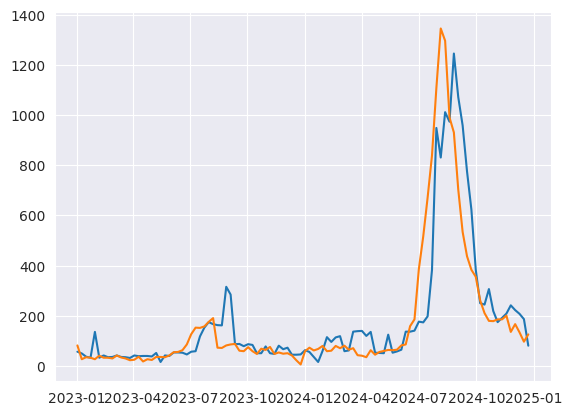

In [32]:
plt.plot(summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Year-Week"], predicted, label="Predicted")
plt.plot(summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Year-Week"], summed_df[(summed_df["Year-Week"].dt.year >= 2023) & (summed_df["Year-Week"].dt.year <= 2024)]["Cases"], label="Actual")

In [27]:
leave_one_season_out_df = pd.DataFrame(columns=["Year", "MAE", "RMSE", "N_week_ahead"])
# local
for i in range(1, 13):
    for year in range(2014,2025):
        actual = [0] * 52
        predictions = [0] * 52
        for municipal in municipals:
            municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
            year_test_start = str(year) + "-01-01"
            year_test_end = str(year) + "-12-31"
            municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
            predicted, MAE, MSE, feature_importance_dict, actuals = train_RF(municipal_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Month", "Week", "Population"], target="Cases", date_col="Year-Week", n_ahead=i, year_test_start=year_test_start, year_test_end=year_test_end)
            actual = [sum(x) for x in zip(actual, actuals)]
            predictions = [sum(x) for x in zip(predictions, predicted)]
            
        MAE = mean_absolute_error(actual, predictions)
        RMSE = np.sqrt(mean_squared_error(actual, predictions))
        leave_one_season_out_df = pd.concat([leave_one_season_out_df, pd.DataFrame({"Year": [year], "MAE": [MAE], "RMSE": [RMSE], "N_week_ahead": [i]})], axis=0)

In [38]:
leave_one_season_out_df.groupby(["N_week_ahead"]).mean()

,Year,MAE,RMSE
N_week_ahead,,,
1,2019.0,38.642191,68.263860
2,2019.0,48.521623,82.689476
3,2019.0,57.746645,98.881282
4,2019.0,69.467172,120.235344
5,2019.0,78.168282,136.913938
6,2019.0,85.171740,149.374078
7,2019.0,90.118722,157.687078
8,2019.0,93.843094,162.115128
9,2019.0,96.243515,163.582751


In [11]:
# save leave_one_season_out_df to csv
leave_one_season_out_df.to_csv("leave_one_season_out_evaluation.csv", index=False)

# Leave One Season Out Evaluation for Pooled Provincial Model

In [12]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
leave_one_season_out_pooled_df = pd.DataFrame(columns=["Municipal", "Year", "MAE", "MSE", "N_week_ahead"])
n_weeks_ahead = range(1,13)
years = range(2014, 2025)
for n in n_weeks_ahead:

    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)

    pooled_df.dropna()
    pooled_X = pooled_df.drop(columns=["Cases", "Year-Week"])
    pooled_y = pooled_df["Cases"]
    for year in years:
        pooled_X_train = pooled_X[(pooled_df["Year-Week"] < str(year) + "-01-01") | (pooled_df["Year-Week"] >= str(year) + "-12-31")]
        pooled_y_train = pooled_y[(pooled_df["Year-Week"] < str(year) + "-01-01") | (pooled_df["Year-Week"] >= str(year) + "-12-31")]
        model = train_RF_provincial(pooled_X_train, pooled_y_train, {'max_depth': 15,
                                                                 'min_samples_leaf': 2,
                                                                 'min_samples_split': 2,
                                                                 'n_estimators': 100})
        actual = [0] * 104 
        predictions = [0] * 104
        for municipal in municipals:
            municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
            municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
            municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
            municipal_X = municipal_df.drop(columns=["Cases", "Year-Week"])
            municipal_y = municipal_df["Cases"]
            municipal_X_test = municipal_X[(municipal_df["Year-Week"] >= str(year) +"-01-01") & (municipal_df["Year-Week"] < str(year) + "-12-31")]
            municipal_y_test = municipal_y[(municipal_df["Year-Week"] >= str(year) + "-01-01") & (municipal_df["Year-Week"] < str(year) + "-12-31")]
            predicted, MAE, MSE, feature_importance_dict = test_RF_provincial(model, municipal_X_test, municipal_y_test)
            actual = [x + y for x, y in zip(actual, municipal_y_test.values)]
            predictions = [x + y for x, y in zip(predictions, predicted)]
        MAE = mean_absolute_error(actual, predictions)
        RMSE = np.sqrt(mean_squared_error(actual, predictions))
        leave_one_season_out_pooled_df = pd.concat([leave_one_season_out_pooled_df, pd.DataFrame({"Year": [year], "MAE": [MAE], "MSE": [RMSE], "N_week_ahead": [n]})], axis=0)

In [23]:
leave_one_season_out_pooled_df.groupby(["N_week_ahead"]).mean()

,Year,MAE,MSE
N_week_ahead,,,
1,2019.0,27.905012,44.006460
2,2019.0,34.260950,56.603000
3,2019.0,42.851729,69.144882
4,2019.0,51.749029,83.532632
5,2019.0,61.556194,99.170176
6,2019.0,72.158680,121.809856
7,2019.0,81.761708,137.610948
8,2019.0,88.661932,149.585699
9,2019.0,95.561866,158.756171


In [15]:
# save leave_one_season_out_df to csv
leave_one_season_out_pooled_df.drop(columns=["Municipal"], inplace = True)
leave_one_season_out_pooled_df.to_csv("leave_one_season_out_pooled_evaluation.csv", index=False)

In [42]:
leave_one_season_out_df = pd.read_csv("leave_one_season_out_evaluation.csv")
leave_one_season_out_pooled_df = pd.read_csv("leave_one_season_out_pooled_evaluation.csv")

In [43]:
leave_one_season_out_pooled_df["RMSE"] = np.sqrt(leave_one_season_out_pooled_df["MSE"])
leave_one_season_out_pooled_df.groupby(["N_week_ahead"]).mean()

,Year,MAE,MSE,RMSE
N_week_ahead,,,,
1,2019.0,27.905012,44.006460,5.851573
2,2019.0,34.260950,56.603000,6.590938
3,2019.0,42.851729,69.144882,7.296527
4,2019.0,51.749029,83.532632,8.128775
5,2019.0,61.556194,99.170176,8.868928
6,2019.0,72.158680,121.809856,9.777831
7,2019.0,81.761708,137.610948,10.470095
8,2019.0,88.661932,149.585699,11.016491
9,2019.0,95.561866,158.756171,11.431833


In [39]:
n_weeks_ahead = range(1,13)
years = range(2014,2025)
leave_one_season_out_summed_df =  pd.DataFrame(columns=["Year", "MAE", "MSE", "N_week_ahead"])
for year in years:
    for n in n_weeks_ahead:
        rf_model = RandomForestModel()
        predicted, MAE, MSE, feature_importance_dict,act = rf_model.train_and_evaluate(data = summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Week", "Population", "Month"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start=f"{year}-01-01", year_test_end=f"{year}-12-31")
        leave_one_season_out_summed_df = pd.concat([leave_one_season_out_summed_df, pd.DataFrame({"Year": [year], "MAE": [MAE], "MSE": [MSE], "N_week_ahead": [n]})], axis=0)

year 2014 with 1-ahead has passed
year 2014 with 2-ahead has passed
year 2014 with 3-ahead has passed
year 2014 with 4-ahead has passed
year 2014 with 5-ahead has passed
year 2014 with 6-ahead has passed
year 2014 with 7-ahead has passed
year 2014 with 8-ahead has passed
year 2014 with 9-ahead has passed
year 2014 with 10-ahead has passed
year 2014 with 11-ahead has passed
year 2014 with 12-ahead has passed
year 2015 with 1-ahead has passed
year 2015 with 2-ahead has passed
year 2015 with 3-ahead has passed
year 2015 with 4-ahead has passed
year 2015 with 5-ahead has passed
year 2015 with 6-ahead has passed
year 2015 with 7-ahead has passed
year 2015 with 8-ahead has passed
year 2015 with 9-ahead has passed
year 2015 with 10-ahead has passed
year 2015 with 11-ahead has passed
year 2015 with 12-ahead has passed
year 2016 with 1-ahead has passed
year 2016 with 2-ahead has passed
year 2016 with 3-ahead has passed
year 2016 with 4-ahead has passed
year 2016 with 5-ahead has passed
year 201

In [35]:
leave_one_season_out_summed_df.groupby(["N_week_ahead"]).mean()

,Year,MAE,MSE
N_week_ahead,,,
1,2019.0,35.723517,20389.986273
2,2019.0,41.557692,22066.687063
3,2019.0,52.326643,25500.935734
4,2019.0,61.373834,28000.381410
5,2019.0,74.764746,37983.690103
6,2019.0,83.209472,45953.123649
7,2019.0,92.209873,55571.324592
8,2019.0,94.266084,56569.899650
9,2019.0,95.414428,55832.959514


In [41]:
leave_one_season_out_summed_df["RMSE"] = np.sqrt(leave_one_season_out_summed_df["MSE"])
leave_one_season_out_summed_df = leave_one_season_out_summed_df.groupby(["N_week_ahead"]).mean()
leave_one_season_out_summed_df

,Year,MAE,MSE,RMSE
N_week_ahead,,,,
1,2019.0,34.959661,19338.991777,67.133775
2,2019.0,41.963287,22493.354895,77.567029
3,2019.0,51.535944,25253.584196,91.351382
4,2019.0,62.431527,29016.829545,109.033325
5,2019.0,74.968075,38481.642292,130.805959
6,2019.0,87.320884,50338.057692,153.796126
7,2019.0,91.886447,55675.863470,163.743310
8,2019.0,95.261189,57867.407343,167.000226
9,2019.0,100.632499,62012.229665,172.416363
